In [ ]:
# Log in to your Hugging Face account to download models
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Install all required Python libraries
!pip install -q -U transformers accelerate peft trl bitsandbytes sentence-transformers faiss-cpu openpyxl streamlit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Build assets

In [ ]:
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import logging
import os
from google.colab import drive

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Mount Google Drive ---
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"
ASSETS_DIR = os.path.join(DRIVE_PROJECT_PATH, "assets")

def create_enhanced_vector_database(main_df, history_df, model):
    """
    Encodes the full conversation history of tickets into vectors
    and saves them in a FAISS index for enhanced retrieval.
    """
    logging.info("Creating ENHANCED vector database for solution retrieval...")

    # --- Step 1: Process and aggregate the history data ---
    logging.info("Aggregating ticket conversation histories...")
    # Drop rows with no description
    history_df = history_df.dropna(subset=['ACTIVITYDESC']).copy() # Use .copy() to avoid SettingWithCopyWarning

    # --- HIGHLIGHTED CHANGE: Convert all activity descriptions to string type ---
    # This line fixes the TypeError by ensuring all items are strings before joining.
    history_df['ACTIVITYDESC'] = history_df['ACTIVITYDESC'].astype(str)

    history_df['CREATEDATE'] = pd.to_datetime(history_df['CREATEDATE'])
    history_df = history_df.sort_values(by=['TICKETID', 'CREATEDATE'])

    # Group by TICKETID and join all descriptions into a single text block
    # This creates a full story for each ticket
    aggregated_history = history_df.groupby('TICKETID')['ACTIVITYDESC'].apply(
        lambda activities: "\n---\n".join(activities)
    ).reset_index()
    aggregated_history.rename(columns={'ACTIVITYDESC': 'FULL_HISTORY'}, inplace=True)

    # --- Step 2: Merge aggregated history back into the main dataframe ---
    logging.info("Merging full histories with main ticket data...")
    merged_df = pd.merge(main_df, aggregated_history, on='TICKETID', how='left')

    # --- Step 3: Create a single "knowledge" column ---
    # We prioritize the full history. If it doesn't exist, we fall back to the final SOLUTION.
    merged_df['KNOWLEDGE_TEXT'] = merged_df['FULL_HISTORY'].fillna(merged_df['SOLUTION'])

    # Filter out tickets that have no knowledge text at all
    df_knowledge = merged_df.dropna(subset=['KNOWLEDGE_TEXT']).copy()
    df_knowledge = df_knowledge[df_knowledge['KNOWLEDGE_TEXT'].str.strip() != '']

    if df_knowledge.empty:
        logging.warning("No knowledge text found to build the vector database. Skipping.")
        return

    # --- Step 4: Encode the new knowledge text and build the FAISS index ---
    logging.info(f"Encoding {len(df_knowledge)} enriched ticket knowledge documents...")
    knowledge_embeddings = model.encode(df_knowledge['KNOWLEDGE_TEXT'].tolist(), convert_to_tensor=True, show_progress_bar=True)

    index = faiss.IndexFlatL2(knowledge_embeddings.shape[1])
    index.add(knowledge_embeddings.cpu().numpy())

    # --- Step 5: Save the new assets ---
    os.makedirs(ASSETS_DIR, exist_ok=True)
    faiss.write_index(index, os.path.join(ASSETS_DIR, "ticket_knowledge.index"))
    df_knowledge.to_pickle(os.path.join(ASSETS_DIR, "ticket_knowledge_data.pkl"))

    logging.info(f"✅ Enhanced vector database saved to '{ASSETS_DIR}'.")


if __name__ == "__main__":
    logging.info("--- Starting Enhanced Asset Building Process ---")

    # Define file paths
    main_tickets_file = "/content/drive/MyDrive/Datel_Project/Copy of Tickets_cleaned.xlsx"
    history_file = "/content/drive/MyDrive/Datel_Project/Ticket history 3.xlsx" # The new history file

    try:
        main_df = pd.read_excel(main_tickets_file)
        history_df = pd.read_excel(history_file)
    except FileNotFoundError as e:
        logging.error(f"FATAL: Could not find a data file. Error: {e}")
        exit()

    # Load the sentence transformer model for creating embeddings
    retrieval_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Create the enhanced vector database using both dataframes
    create_enhanced_vector_database(main_df, history_df, retrieval_model)

    logging.info("--- Asset Building Complete ---")
    print("--- Asset Building Complete ---")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/165 [00:00<?, ?it/s]

--- Asset Building Complete ---


#2. Model Training
##2.1 Mistral

In [ ]:
# --- Complete Training Script for the Mistral Model ---
import pandas as pd
import torch
import json
import gc
import os
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from datasets import Dataset
import logging
from google.colab import drive
import numpy as np
import random

# --- Global Random Seed Settings ---
def set_seed(seed_value=42):
    """
    Sets the random seeds for all relevant libraries to ensure reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # For multi-GPU setups.
        # The following two lines are crucial for ensuring CUDA operations are deterministic.
        # Note: This may slightly reduce computational speed.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function at the beginning of your script's main execution flow.
set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Mount Google Drive ---
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"
MODELS_DIR = os.path.join(DRIVE_PROJECT_PATH, "saved_models")

# --- DATA LOADING AND PREPARATION ---
def load_and_prepare_data(filepath="/content/drive/MyDrive/Datel_Project/Copy of Tickets_cleaned.xlsx"):
    logging.info(f"🔄 Loading and preparing data from '{filepath}'...")
    df = pd.read_excel(filepath)
    df = df.drop(columns=['ACCOUNTID', 'ACCOUNT', 'TICKETID', 'ALTERNATEKEYSUFFIX'], errors='ignore')
    df['SUBJECT'] = df['SUBJECT'].fillna('').astype(str)
    df['PROBLEM'] = df['PROBLEM'].fillna('').astype(str)

    # Use 'ISSUE' as a target column
    for col in ['ISSUE', 'CATEGORY', 'URGENCYCODE']:
        df[col] = df[col].fillna('Unknown').astype(str)

    df['fullText'] = (df['SUBJECT'].str.strip() + " | " + df['PROBLEM'].str.strip()).str.strip()
    df = df[df['fullText'].str.len() > 10]

    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['URGENCYCODE'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['URGENCYCODE'])
    return train_df, val_df, test_df

# --- Simplified Prompt Engineering ---
def create_super_simple_prompt(row):
    subject = str(row['SUBJECT']).strip()
    problem = str(row['PROBLEM']).strip()

    issue_value = str(row['ISSUE']).strip() if str(row['ISSUE']).strip() != 'nan' else 'Unknown'
    category_value = str(row['CATEGORY']).strip()
    urgency_value = str(row['URGENCYCODE']).strip()

    return f"""Classify this ticket:

Subject: {subject}
Problem: {problem}

Output this exact format:
```json
{{
  "ISSUE": "{issue_value}",
  "CATEGORY": "{category_value}",
  "URGENCYCODE": "{urgency_value}"
}}
```"""

# --- MODEL TRAINING ---
def train_mistral_model(model_name, train_df, val_df=None):
    logging.info(f"🚀 Starting training for: {model_name}")
    start_time = time.time()

    train_df_copy = train_df.copy()
    train_df_copy['text'] = train_df_copy.apply(create_super_simple_prompt, axis=1)
    train_dataset = Dataset.from_pandas(train_df_copy[['text']])

    # Print some examples to see the format
    print("=== Training Examples ===")
    for i in range(min(3, len(train_dataset))):
        print(f"Example {i+1}:")
        print(train_dataset[i]['text'])
        print("-" * 50)

    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16, trust_remote_code=True, low_cpu_mem_usage=True)
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], lora_dropout=0.1, bias="none", task_type="CAUSAL_LM")
    model = get_peft_model(model, lora_config)

    output_dir = os.path.join(MODELS_DIR, f"{model_name.split('/')[-1]}_optimized_v16")
    training_args = TrainingArguments(output_dir=output_dir, overwrite_output_dir=True, per_device_train_batch_size=1, gradient_accumulation_steps=16, gradient_checkpointing=True, learning_rate=5e-5, warmup_steps=100, weight_decay=0.01, num_train_epochs=3, save_strategy="epoch", save_total_limit=1, logging_steps=50, report_to="none", fp16=False, bf16=True, seed=42)

    def formatting_func(example):
        return example['text']

    trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        args=training_args,
        processing_class=tokenizer,
        peft_config=lora_config,
        formatting_func=formatting_func,
    )

    train_result = trainer.train()
    training_time = time.time() - start_time

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Save training metrics
    training_metrics = {
        "training_loss": train_result.training_loss,
        "training_time_hours": training_time/3600,
        "total_steps": train_result.global_step,
        "model_name": model_name,
        "dataset_size": len(train_dataset),
    }

    with open(os.path.join(output_dir, "training_metrics.json"), 'w') as f:
        json.dump(training_metrics, f, indent=2)

    return trainer.model, tokenizer, output_dir

# --- MODEL EVALUATION ---
def evaluate_model_comprehensive(model, tokenizer, test_df, model_name, model_path):
    logging.info(f"🔄 Evaluating model: {model_name}")
    model.eval()
    predictions, true_labels = [], []
    eval_df = test_df.sample(n=min(200, len(test_df)), random_state=42)

    for _, row in eval_df.iterrows():
        # --- HIGHLIGHTED CHANGE: Convert all ground truth labels to strings ---
        # This ensures a fair comparison with the model's text-based output.
        true_labels.append({
            "ISSUE": str(row['ISSUE']),
            "CATEGORY": str(row['CATEGORY']),
            "URGENCYCODE": str(row['URGENCYCODE'])
        })

        subject = str(row['SUBJECT']).strip()
        problem = str(row['PROBLEM']).strip()

        prompt = f"""Classify this ticket:

Subject: {subject}
Problem: {problem}

Output this exact format:
```json
"""
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)

        # --- HIGHLIGHTED CHANGE: Added autocast for mixed-precision inference ---
        # This context manager handles the dtype conversion automatically.
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                outputs = model.generate(**inputs, max_new_tokens=100, do_sample=False, pad_token_id=tokenizer.eos_token_id)

        prediction_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        try:
            json_str = prediction_text.split("```json")[1].split("```")[0].strip()
            pred_labels = json.loads(json_str)
            predictions.append({
                "ISSUE": str(pred_labels.get("ISSUE", "Unknown")),
                "CATEGORY": str(pred_labels.get("CATEGORY", "Unknown")),
                "URGENCYCODE": str(pred_labels.get("URGENCYCODE", "Unknown"))
            })
        except (IndexError, json.JSONDecodeError):
            predictions.append({"ISSUE": "Parse Error", "CATEGORY": "Parse Error", "URGENCYCODE": "Parse Error"})

    # Evaluation
    fields = ["ISSUE", "CATEGORY", "URGENCYCODE"]
    results = {}
    print(f"\n📊 {model_name} Evaluate result")

    for field in fields:
        y_true = [label[field] for label in true_labels]
        y_pred = [pred[field] for pred in predictions]
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

        results[field] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        }
        print(f"\n{field}:\n  Accuracy: {accuracy:.4f}\n  F1: {f1:.4f}\n  precision: {precision:.4f}\n  recall: {recall:.4f}")

    # overall result
    overall_accuracy = np.mean([results[field]["accuracy"] for field in fields])
    overall_f1 = np.mean([results[field]["f1_score"] for field in fields])
    overall_precision = np.mean([results[field]["precision"] for field in fields])
    overall_recall = np.mean([results[field]["recall"] for field in fields])

    results["overall"] = {
        "accuracy": overall_accuracy,
        "f1_score": overall_f1,
        "precision": overall_precision,
        "recall": overall_recall
    }

    print(f"\nOverall evaluation:\n  Accuracy: {overall_accuracy:.4f}\n  F1: {overall_f1:.4f}\n  precision: {overall_precision:.4f}\n  recall: {overall_recall:.4f}")

    with open(os.path.join(model_path, "evaluation_results.json"), 'w') as f:
        json.dump(results, f, indent=2)

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    train_data, val_data, test_data = load_and_prepare_data()
    if train_data is not None:
        # Specify the Mistral model to be trained
        model_name = "mistralai/Mistral-7B-Instruct-v0.2"
        try:
            trained_model, trained_tokenizer, model_path = train_mistral_model(model_name, train_data, val_data)
            evaluate_model_comprehensive(trained_model, trained_tokenizer, test_data, model_name, model_path)
            del trained_model, trained_tokenizer
            gc.collect()
            torch.cuda.empty_cache()
        except Exception as e:
            logging.error(f"❌ Error processing {model_name}: {str(e)}", exc_info=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Training Examples ===
Example 1:
Classify this ticket:

Subject: 
Problem: I'm currently struggling to get access to sage, and other users are experiencing the same issue at our company. 

Would this be something you'd be able to help with please?

Below is a snippet of the error message I'm receiving.

Output this exact format:
```json
{
  "ISSUE": "Login problems",
  "CATEGORY": "S1000v3",
  "URGENCYCODE": "5"
}
```
--------------------------------------------------
Example 2:
Classify this ticket:

Subject: COFNRIMATION ISSUES
Problem: I am having further issues with confirming orders on sage and the confirmations not being sent to customers.

Customer has just flagged the following orders:

1.	 /
2.	 / 
3.	 / 

Please can you look into this?

Output this exact format:
```json
{
  "ISSUE": "Unknown",
  "CATEGORY": "S1000v4",
  "URGENCYCODE": "3"
}
```


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'mistralai/Mistral-7B-Instruct-v0.2' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
50,2.072800
100,1.311900
150,1.201400
200,1.195900
250,1.153800
300,1.061000
350,1.061400
400,1.063000
450,1.053300
500,0.900700


/tmp/ipython-input-1157478327.py:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



📊 mistralai/Mistral-7B-Instruct-v0.2 Evaluate result

ISSUE:
  Accuracy: 0.8300
  F1: 0.8259
  precision: 0.8314
  recall: 0.8300

CATEGORY:
  Accuracy: 0.7800
  F1: 0.6999
  precision: 0.8249
  recall: 0.7800

URGENCYCODE:
  Accuracy: 0.8900
  F1: 0.8573
  precision: 0.8839
  recall: 0.8900

Overall evaluation:
  Accuracy: 0.8333
  F1: 0.7943
  precision: 0.8468
  recall: 0.8333


##2.2 Gemma

In [ ]:
# # --- redesign prompt engineer ---
# def create_enhanced_prompt(row):
#     subject = str(row['SUBJECT']).strip()
#     problem = str(row['PROBLEM']).strip()

#     # make sure the format is the same
#     issue_value = str(row['ISSUE']).strip() if str(row['ISSUE']).strip() != 'nan' else 'Unknown'
#     category_value = str(row['CATEGORY']).strip()
#     urgency_value = str(row['URGENCYCODE']).strip()

#     return f"""### INSTRUCTION
# You are a ticket classifier. You MUST output EXACTLY this JSON format with these EXACT field names:

# ### REQUIRED FORMAT
# ```json
# {{
#   "ISSUE": "value",
#   "CATEGORY": "value",
#   "URGENCYCODE": "value"
# }}
# ```

# ### VALID VALUES
# ISSUE: Reports, Inventory, Access, Database, Configuration, Other
# CATEGORY: S1000, S1000v3, S1000v4, S1000v5, CRM, Other
# URGENCYCODE: 1, 2, 3, 4

# ### EXAMPLES
# Password issue → {{"ISSUE": "Access", "CATEGORY": "S1000v3", "URGENCYCODE": "3"}}
# Report problem → {{"ISSUE": "Reports", "CATEGORY": "S1000", "URGENCYCODE": "2"}}
# Database query → {{"ISSUE": "Database", "CATEGORY": "S1000v4", "URGENCYCODE": "1"}}

# ### TICKET
# Subject: {subject}
# Problem: {problem}

# ### OUTPUT
# ```json
# {{
#   "ISSUE": "{issue_value}",
#   "CATEGORY": "{category_value}",
#   "URGENCYCODE": "{urgency_value}"
# }}
# ```"""

# # --- Stricter training version ---
# def create_strict_format_prompt(row):
#     subject = str(row['SUBJECT']).strip()
#     problem = str(row['PROBLEM']).strip()

#     issue_value = str(row['ISSUE']).strip() if str(row['ISSUE']).strip() != 'nan' else 'Unknown'
#     category_value = str(row['CATEGORY']).strip()
#     urgency_value = str(row['URGENCYCODE']).strip()

#     return f"""Classify this IT ticket using EXACTLY this format:

# TICKET:
# Subject: {subject}
# Problem: {problem}

# CLASSIFICATION:
# ```json
# {{
#   "ISSUE": "{issue_value}",
#   "CATEGORY": "{category_value}",
#   "URGENCYCODE": "{urgency_value}"
# }}
# ```"""

# --- Complete version of modified training script ---
import pandas as pd
import torch
import json
import gc
import os
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from datasets import Dataset
import logging
from google.colab import drive
import numpy as np
import random

# --- Global Random Seed Settings ---
def set_seed(seed_value=42):
    """
    Sets the random seeds for all relevant libraries to ensure reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # For multi-GPU setups.
        # The following two lines are crucial for ensuring CUDA operations are deterministic.
        # Note: This may slightly reduce computational speed.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function at the beginning of your script's main execution flow.
set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Mount Google Drive ---
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"
MODELS_DIR = os.path.join(DRIVE_PROJECT_PATH, "saved_models")

# --- DATA LOADING AND PREPARATION ---
def load_and_prepare_data(filepath="Copy of Tickets_cleaned.xlsx"):
    logging.info(f"🔄 Loading and preparing data from '{filepath}'...")
    df = pd.read_excel(filepath)
    df = df.drop(columns=['ACCOUNTID', 'ACCOUNT', 'TICKETID', 'ALTERNATEKEYSUFFIX'], errors='ignore')
    df['SUBJECT'] = df['SUBJECT'].fillna('').astype(str)
    df['PROBLEM'] = df['PROBLEM'].fillna('').astype(str)

    # --- deal with missing value ---
    df['ISSUE'] = df['ISSUE'].fillna('Unknown').astype(str)
    df['CATEGORY'] = df['CATEGORY'].fillna('Unknown').astype(str)
    df['URGENCYCODE'] = df['URGENCYCODE'].fillna('3').astype(str)  # set it as medium level

    df['fullText'] = (df['SUBJECT'].str.strip() + " | " + df['PROBLEM'].str.strip()).str.strip()
    df = df[df['fullText'].str.len() > 10]

    # Print data analysis to understand categories
    print("=== DATA ANALYSIS ===")
    print("\nCATEGORY distribution:")
    print(df['CATEGORY'].value_counts())
    print("\nURGENCYCODE distribution:")
    print(df['URGENCYCODE'].value_counts())
    print("\nISSUE distribution (Top 10):")
    print(df['ISSUE'].value_counts().head(10))

    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['URGENCYCODE'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['URGENCYCODE'])
    return train_df, val_df, test_df

# --- Simplified Prompt Engineering ---
def create_super_simple_prompt(row):
    subject = str(row['SUBJECT']).strip()
    problem = str(row['PROBLEM']).strip()

    issue_value = str(row['ISSUE']).strip() if str(row['ISSUE']).strip() != 'nan' else 'Unknown'
    category_value = str(row['CATEGORY']).strip()
    urgency_value = str(row['URGENCYCODE']).strip()

    return f"""Classify this ticket:

Subject: {subject}
Problem: {problem}

Output this exact format:
```json
{{
  "ISSUE": "{issue_value}",
  "CATEGORY": "{category_value}",
  "URGENCYCODE": "{urgency_value}"
}}
```"""

# --- MODEL TRAINING ---
def train_optimized_model(model_name, train_df, val_df=None):
    logging.info(f"🚀 Starting training for: {model_name}")
    start_time = time.time()

    train_df_copy = train_df.copy()
    # Use the simplified prompt
    train_df_copy['text'] = train_df_copy.apply(create_super_simple_prompt, axis=1)
    train_dataset = Dataset.from_pandas(train_df_copy[['text']])

    # Print some examples to see the format
    print("=== Training Examples ===")
    for i in range(min(3, len(train_dataset))):
        print(f"Example {i+1}:")
        print(train_dataset[i]['text'])
        print("-" * 50)

    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16, trust_remote_code=True, low_cpu_mem_usage=True)
    lora_config = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], lora_dropout=0.1, bias="none", task_type="CAUSAL_LM")
    model = get_peft_model(model, lora_config)

    output_dir = os.path.join(MODELS_DIR, f"{model_name.split('/')[-1]}_optimized")  # v15 version
    training_args = TrainingArguments(output_dir=output_dir, overwrite_output_dir=True, per_device_train_batch_size=1, gradient_accumulation_steps=16, gradient_checkpointing=True, learning_rate=5e-5, warmup_steps=100, weight_decay=0.01, num_train_epochs=3, save_strategy="epoch", save_total_limit=1, logging_steps=50, report_to="none", fp16=False, bf16=True, seed=42)  # 增加到3個epoch

    def formatting_func(example):
        return example['text']

    trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        args=training_args,
        processing_class=tokenizer,
        peft_config=lora_config,
        formatting_func=formatting_func,
    )

    train_result = trainer.train()
    training_time = time.time() - start_time

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Save training metrics
    training_metrics = {
        "training_loss": train_result.training_loss,
        "training_time_hours": training_time/3600,
        "total_steps": train_result.global_step,
        "model_name": model_name,
        "dataset_size": len(train_dataset),
    }

    with open(os.path.join(output_dir, "training_metrics.json"), 'w') as f:
        json.dump(training_metrics, f, indent=2)

    return trainer.model, tokenizer, output_dir

# --- MODEL EVALUATION ---
def evaluate_model_comprehensive(model, tokenizer, test_df, model_name, model_path):
    logging.info(f"🔄 Evaluating model: {model_name}")
    model.eval()
    predictions, true_labels = [], []
    eval_df = test_df.sample(n=min(200, len(test_df)), random_state=42)  # reduce training samples

    for _, row in eval_df.iterrows():
        true_labels.append({"ISSUE": row['ISSUE'], "CATEGORY": row['CATEGORY'], "URGENCYCODE": row['URGENCYCODE']})

        subject = str(row['SUBJECT']).strip()
        problem = str(row['PROBLEM']).strip()

        # Use the format same as training
        prompt = f"""Classify this ticket:

Subject: {subject}
Problem: {problem}

Output this exact format:
```json
"""
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        prediction_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        try:
            json_str = prediction_text.split("```json")[1].split("```")[0].strip()
            pred_labels = json.loads(json_str)
            predictions.append({
                "ISSUE": pred_labels.get("ISSUE", "Unknown"),
                "CATEGORY": pred_labels.get("CATEGORY", "Unknown"),
                "URGENCYCODE": str(pred_labels.get("URGENCYCODE", "Unknown"))
            })
        except (IndexError, json.JSONDecodeError):
            predictions.append({"ISSUE": "Parse Error", "CATEGORY": "Parse Error", "URGENCYCODE": "Parse Error"})

    # evaluation
    fields = ["ISSUE", "CATEGORY", "URGENCYCODE"]
    results = {}
    print(f"\n📊 {model_name} Evaluate result")

    for field in fields:
        y_true = [label[field] for label in true_labels]
        y_pred = [pred[field] for pred in predictions]
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

        results[field] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        }
        print(f"\n{field}:\n  Accuracy: {accuracy:.4f}\n  F1: {f1:.4f}\n  precision: {precision:.4f}\n  recall: {recall:.4f}")

    # overall result
    overall_accuracy = np.mean([results[field]["accuracy"] for field in fields])
    overall_f1 = np.mean([results[field]["f1_score"] for field in fields])
    overall_precision = np.mean([results[field]["precision"] for field in fields])
    overall_recall = np.mean([results[field]["recall"] for field in fields])

    results["overall"] = {
        "accuracy": overall_accuracy,
        "f1_score": overall_f1,
        "precision": overall_precision,
        "recall": overall_recall
    }

    print(f"\nOverall evaluation:\n  Accuracy: {overall_accuracy:.4f}\n  F1: {overall_f1:.4f}\n  precision: {overall_precision:.4f}\n  recall: {overall_recall:.4f}")

    with open(os.path.join(model_path, "evaluation_results.json"), 'w') as f:
        json.dump(results, f, indent=2)

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    train_data, val_data, test_data = load_and_prepare_data()
    if train_data is not None:
        models_to_run = ["google/gemma-2b-it"]  # run gemma first
        for model_name in models_to_run:
            try:
                trained_model, trained_tokenizer, model_path = train_optimized_model(model_name, train_data, val_data)
                evaluate_model_comprehensive(trained_model, trained_tokenizer, test_data, model_name, model_path)
                del trained_model, trained_tokenizer
                gc.collect()
                torch.cuda.empty_cache()
            except Exception as e:
                logging.error(f"❌ Error processing {model_name}: {str(e)}", exc_info=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== DATA ANALYSIS ===

CATEGORY distribution:
CATEGORY
S1000v4        4121
S1000v3         768
S1000           293
S1000v4/CRM      16
S1000/CRM         1
Name: count, dtype: int64

URGENCYCODE distribution:
URGENCYCODE
3    4556
1     541
5      71
4      31
Name: count, dtype: int64

ISSUE distribution (Top 10):
ISSUE
Unknown        3704
Inventory       490
Printing        171
Cashbook        111
MTD Query       111
Reports          90
Performance      80
MS               65
Paperless        60
EDI              54
Name: count, dtype: int64
=== Training Examples ===
Example 1:
Classify this ticket:

Subject: 
Problem: I'm currently struggling to get access to sage, and other users are experiencing the same issue at our company. 

Would this be something you'd be able to help with please?

Below is a snippet of the error message I'm receiving.

Output this ex

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'google/gemma-2b-it' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3639 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
50,3.719900
100,1.749900
150,1.547300
200,1.524100
250,1.481200
300,1.387100
350,1.388000
400,1.392400
450,1.381400
500,1.235100



📊 google/gemma-2b-it Evaluate result

ISSUE:
  Accuracy: 0.8250
  F1: 0.8184
  precision: 0.8214
  recall: 0.8250

CATEGORY:
  Accuracy: 0.7700
  F1: 0.6839
  precision: 0.6302
  recall: 0.7700

URGENCYCODE:
  Accuracy: 0.8900
  F1: 0.8573
  precision: 0.8839
  recall: 0.8900

Overall evaluation:
  Accuracy: 0.8283
  F1: 0.7865
  precision: 0.7785
  recall: 0.8283


##2.3 BERT

In [ ]:
import pandas as pd
import torch
import json
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from datasets import Dataset
import logging
from google.colab import drive
import numpy as np
import joblib

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Mount Google Drive & Define Paths ---
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"
MODELS_DIR = os.path.join(DRIVE_PROJECT_PATH, "saved_models") # New version folder
os.makedirs(MODELS_DIR, exist_ok=True)

# --- DATA LOADING AND PREPARATION ---
def load_and_prepare_data(filepath="/content/drive/MyDrive/Datel_Project/Copy of Tickets_cleaned.xlsx"):
    """Loads and prepares data, splitting it into train, validation, and test sets."""
    logging.info(f"🔄 Loading and preparing data from '{filepath}'...")
    df = pd.read_excel(filepath)
    df = df.drop(columns=['ACCOUNTID', 'ACCOUNT', 'TICKETID', 'ALTERNATEKEYSUFFIX'], errors='ignore')

    # Clean and fill missing values
    df['SUBJECT'] = df['SUBJECT'].fillna('').astype(str)
    df['PROBLEM'] = df['PROBLEM'].fillna('').astype(str)
    df['ISSUE'] = df['ISSUE'].fillna('Unknown').astype(str)
    df['CATEGORY'] = df['CATEGORY'].fillna('Unknown').astype(str)
    df['URGENCYCODE'] = df['URGENCYCODE'].fillna('3').astype(str)

    df['fullText'] = (df['SUBJECT'].str.strip() + " | " + df['PROBLEM'].str.strip()).str.strip()
    df = df[df['fullText'].str.len() > 10]

    df['labels'] = df.apply(
        lambda row: [
            f"ISSUE:{row['ISSUE']}",
            f"CATEGORY:{row['CATEGORY']}",
            f"URGENCYCODE:{row['URGENCYCODE']}"
        ],
        axis=1
    )

    # Create a 3-way split (train, validation, test)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['URGENCYCODE'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['URGENCYCODE'])

    logging.info(f"✅ Data loaded. Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)} rows.")
    return train_df, val_df, test_df

# --- HIGHLIGHTED CHANGE: New function for detailed, per-category evaluation ---
def evaluate_bert_macro(trainer, test_dataset, mlb, output_dir):
    """
    Performs a detailed evaluation by calculating metrics for each category separately.
    """
    logging.info("📊 Performing detailed, per-category (macro) evaluation...")

    # 1. Get model predictions
    predictions_output = trainer.predict(test_dataset)
    logits = predictions_output.predictions
    true_labels_binary = predictions_output.label_ids

    # 2. Convert logits to binary predictions
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    predictions_binary = np.zeros(probs.shape)
    predictions_binary[np.where(probs > 0.5)] = 1

    # 3. Decode binary predictions back to text labels using the binarizer
    predicted_labels_text = mlb.inverse_transform(predictions_binary)
    true_labels_text = mlb.inverse_transform(true_labels_binary)

    # 4. Parse the text labels into dictionaries
    def parse_labels(label_tuples):
        parsed = []
        for label_tuple in label_tuples:
            d = {"ISSUE": "Unknown", "CATEGORY": "Unknown", "URGENCYCODE": "Unknown"}
            for label in label_tuple:
                key, value = label.split(":", 1)
                d[key] = value
            parsed.append(d)
        return parsed

    y_pred_parsed = parse_labels(predicted_labels_text)
    y_true_parsed = parse_labels(true_labels_text)

    # 5. Calculate metrics for each field
    fields = ["ISSUE", "CATEGORY", "URGENCYCODE"]
    results = {}

    print("\n" + "="*50)
    print("📊 DETAILED BERT EVALUATION (MACRO)")
    print("="*50)

    for field in fields:
        y_true = [d[field] for d in y_true_parsed]
        y_pred = [d[field] for d in y_pred_parsed]

        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

        results[field] = {
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        }
        print(f"\n{field} Classification:")
        print(f"  - Accuracy:  {accuracy:.4f}")
        print(f"  - F1 Score:  {f1:.4f}")
        print(f"  - Precision: {precision:.4f}")
        print(f"  - Recall:    {recall:.4f}")

    # 6. Calculate and print overall macro-average results
    overall_accuracy = np.mean([results[field]["accuracy"] for field in fields])
    overall_f1 = np.mean([results[field]["f1_score"] for field in fields])
    # --- ADDED PRECISION AND RECALL CALCULATION ---
    overall_precision = np.mean([results[field]["precision"] for field in fields])
    overall_recall = np.mean([results[field]["recall"] for field in fields])

    results["overall_macro_average"] = {
        "accuracy": overall_accuracy,
        "f1_score": overall_f1,
        "precision": overall_precision,
        "recall": overall_recall
    }

    print("\n" + "-"*50)
    print("OVERALL MACRO-AVERAGE:")
    print(f"  - Avg Accuracy: {overall_accuracy:.4f}")
    print(f"  - Avg F1 Score: {overall_f1:.4f}")
    # --- ADDED PRECISION AND RECALL TO PRINTOUT ---
    print(f"  - Avg Precision: {overall_precision:.4f}")
    print(f"  - Avg Recall: {overall_recall:.4f}")
    print("="*50)

    # 7. Save the detailed results to a new file
    results_path = os.path.join(output_dir, "evaluation_results_detailed.json")
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    logging.info(f"💾 Detailed evaluation results saved to {results_path}")


# --- BERT MODEL TRAINING & EVALUATION ---
def train_bert_classifier(train_df, val_df, test_df, model_name="bert-base-uncased"):
    logging.info(f"🚀 Starting BERT training for: {model_name}")

    # Encode Labels
    mlb = MultiLabelBinarizer()
    train_labels = mlb.fit_transform(train_df['labels'])
    val_labels = mlb.transform(val_df['labels'])
    test_labels = mlb.transform(test_df['labels'])

    # Save the Binarizer
    output_dir = os.path.join(MODELS_DIR, f"{model_name.split('/')[-1]}_triage")
    os.makedirs(output_dir, exist_ok=True)
    binarizer_path = os.path.join(output_dir, "mlb_binarizer.joblib")
    joblib.dump(mlb, binarizer_path)
    logging.info(f"💾 Label binarizer saved to {binarizer_path}")

    # Tokenize Text
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_encodings = tokenizer(train_df['fullText'].tolist(), truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_df['fullText'].tolist(), truncation=True, padding=True, max_length=512)
    test_encodings = tokenizer(test_df['fullText'].tolist(), truncation=True, padding=True, max_length=512)

    # Create PyTorch Datasets
    class TicketDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
            return item
        def __len__(self):
            return len(self.labels)

    train_dataset = TicketDataset(train_encodings, train_labels)
    val_dataset = TicketDataset(val_encodings, val_labels)
    test_dataset = TicketDataset(test_encodings, test_labels)

    # Define Micro-Average Metrics for Trainer
    def compute_metrics_micro(p: EvalPrediction):
        logits = p.predictions
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(logits))
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs > 0.5)] = 1
        f1_micro = f1_score(y_true=p.label_ids, y_pred=predictions, average="micro")
        return {"f1_micro": f1_micro}

    # Configure and Train the Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_), problem_type="multi_label_classification")
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_micro,
    )

    logging.info("🏋️‍♀️ Fine-tuning BERT model...")
    trainer.train()

    # --- Final Evaluation and Saving ---
    logging.info("📊 Performing final micro-average evaluation...")
    eval_results_micro = trainer.evaluate(eval_dataset=test_dataset)

    print("\n" + "="*50)
    print("📊 FINAL BERT EVALUATION (MICRO-AVERAGE)")
    print("="*50)
    for key, value in eval_results_micro.items():
        print(f"  - {key}: {value:.4f}")
    print("="*50)

    results_path_micro = os.path.join(output_dir, "evaluation_results_micro.json")
    with open(results_path_micro, 'w') as f:
        json.dump(eval_results_micro, f, indent=2)
    logging.info(f"💾 Micro-average results saved to {results_path_micro}")

    # --- HIGHLIGHTED CHANGE: Call the new macro evaluation function ---
    evaluate_bert_macro(trainer, test_dataset, mlb, output_dir)

    # Save the final model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    logging.info(f"✅ Model, tokenizer, and binarizer saved to {output_dir}")

# --- MAIN EXECUTION SCRIPT ---
if __name__ == "__main__":
    logging.info("🚀 Starting BERT Training and Evaluation Pipeline")
    if not torch.cuda.is_available():
        logging.error("❌ GPU not available. This script requires a GPU.")
    else:
        logging.info(f"✅ GPU detected: {torch.cuda.get_device_name()}")

    train_data, val_data, test_data = load_and_prepare_data()
    if train_data is not None:
        train_bert_classifier(train_data, val_data, test_data)
        logging.info("🎉 BERT pipeline completed successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ISSUE:GL', 'ISSUE:MTD Patch'] will be ignored
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro
1,0.277600,0.150973,0.808974
2,0.109800,0.093273,0.808974
3,0.094500,0.084783,0.824651
4,0.083400,0.079021,0.830347



📊 FINAL BERT EVALUATION (MICRO-AVERAGE)
  - eval_loss: 0.0833
  - eval_f1_micro: 0.8174
  - eval_runtime: 2.8492
  - eval_samples_per_second: 273.7620
  - eval_steps_per_second: 17.1980
  - epoch: 4.0000

📊 DETAILED BERT EVALUATION (MACRO)

ISSUE Classification:
  - Accuracy:  0.7282
  - F1 Score:  0.6249
  - Precision: 0.6058
  - Recall:    0.7282

CATEGORY Classification:
  - Accuracy:  0.8013
  - F1 Score:  0.7234
  - Precision: 0.6902
  - Recall:    0.8013

URGENCYCODE Classification:
  - Accuracy:  0.8910
  - F1 Score:  0.8512
  - Precision: 0.8839
  - Recall:    0.8910

--------------------------------------------------
OVERALL MACRO-AVERAGE:
  - Avg Accuracy: 0.8068
  - Avg F1 Score: 0.7332
  - Avg Precision: 0.7266
  - Avg Recall: 0.8068


#3. Prototype
Write 3_prototype_app_improved.py and then run it in your ngork

In [ ]:
%%writefile 3_prototype_app_improved.py
# --- Complete Prototype Script with Enhanced RAG and Stable JSON Output ---
import streamlit as st
import torch
import json
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import logging
import os
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

# --- CONFIGURATION & SETUP ---
logging.basicConfig(level=logging.ERROR)


DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Datel_Project"
ASSETS_DIR = os.path.join(DRIVE_PROJECT_PATH, "assets")
MISTRAL_MODEL_PATH = os.path.join(DRIVE_PROJECT_PATH, "saved_models", "Mistral-7B-Instruct-v0.2_optimized_v16")

# --- RESOURCE LOADING (CACHED FOR PERFORMANCE) ---
@st.cache_resource
def load_all_models_and_assets():
    """
    Loads all necessary models and assets for the ENHANCED RAG pipeline.
    ALSO dynamically builds the validation categories from the data.
    """
    assets = {}
    st.info("🔄 Loading all required AI models and assets...")

    # 1. Load ENHANCED RAG Retriever Assets
    try:
        assets['faiss_index'] = faiss.read_index(os.path.join(ASSETS_DIR, "ticket_knowledge.index"))
        ticket_df = pd.read_pickle(os.path.join(ASSETS_DIR, "ticket_knowledge_data.pkl"))

        # Handle NaN values in the 'ISSUE' column by replacing them with 'Unknown'
        ticket_df['ISSUE'] = ticket_df['ISSUE'].fillna('Unknown')

        assets['ticket_data'] = ticket_df
        assets['retrieval_model'] = SentenceTransformer('all-MiniLM-L6-v2')
        st.write("✅ Enhanced Retriever assets loaded.")
    except Exception as e:
        st.error(f"Failed to load retriever assets from {ASSETS_DIR}. Please run the '1_build_assets.py' script first. Error: {e}")
        return None, None

    # 2. Dynamically create the valid categories from the loaded data
    try:
        valid_categories = {
            "ISSUE": sorted(ticket_df['ISSUE'].unique().tolist()), # Sorted for consistency
            "CATEGORY": ["S1000v4", "S1000v3", "S1000", "S1000v4/CRM", "S1000/CRM"],
            "URGENCYCODE": ["1", "3", "4", "5"]
        }
        st.write(f"✅ Dynamically loaded {len(valid_categories['ISSUE'])} unique ISSUE types.")
    except KeyError as e:
        st.error(f"Error: Column '{e}' not found in 'ticket_knowledge_data.pkl'. Cannot create dynamic categories.")
        return None, None

    # 3. Load Mistral (for both Classification and Generation)
    try:
        mistral_base_model_name = "mistralai/Mistral-7B-Instruct-v0.2"
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True
        )
        mistral_base_model = AutoModelForCausalLM.from_pretrained(
            mistral_base_model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.bfloat16
        )
        assets['mistral_tokenizer'] = AutoTokenizer.from_pretrained(mistral_base_model_name)
        if assets['mistral_tokenizer'].pad_token is None:
            assets['mistral_tokenizer'].pad_token = assets['mistral_tokenizer'].eos_token
        assets['mistral_model'] = PeftModel.from_pretrained(mistral_base_model, MISTRAL_MODEL_PATH)
        assets['mistral_model'].eval()
        st.write("✅ Mistral model loaded.")
    except Exception as e:
        st.error(f"Failed to load Mistral model from {MISTRAL_MODEL_PATH}. Error: {e}")
        return None, None

    st.success("🎉 All AI components are loaded and ready!")
    return assets, valid_categories

# --- IMPROVED JSON PARSING FUNCTIONS ---
def extract_json_from_text(text):
    """
    Robustly extracts a JSON object from a string, trying various patterns.
    """
    # Pattern 1: Code block with ```json
    match = re.search(r'```json\s*(\{.*?\})\s*```', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1))
        except json.JSONDecodeError:
            pass

    # Pattern 2: Any code block ```
    match = re.search(r'```\s*(\{.*?\})\s*```', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1))
        except json.JSONDecodeError:
            pass

    # Pattern 3: A standalone JSON object
    match = re.search(r'(\{.*?\})', text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1))
        except json.JSONDecodeError:
            pass

    return None

def validate_and_fix_classification(classification_dict, valid_categories):
    """
    Validates classification results against the allowed values and fixes them.
    """
    if not isinstance(classification_dict, dict):
        return {"ISSUE": "Unknown", "CATEGORY": "S1000v4", "URGENCYCODE": "3"}

    result = {}
    for field, valid_values in valid_categories.items():
        predicted_value = str(classification_dict.get(field, "")).strip()

        if predicted_value in valid_values:
            result[field] = predicted_value
        else:
            # Fallback to the most common value if validation fails
            if field == "ISSUE":
                result[field] = "Unknown"
            elif field == "CATEGORY":
                result[field] = "S1000v4"
            else: # URGENCYCODE
                result[field] = "3"
    return result

# --- BACKEND LOGIC ---
@torch.no_grad()
def run_mistral_classification(subject, problem, assets, valid_categories, max_retries=3):
    """
    Uses the fine-tuned Mistral model to classify the ticket with improved stability.
    """
    model = assets['mistral_model']
    tokenizer = assets['mistral_tokenizer']

    # Dynamically create the valid values list for the prompt
    issue_list_str = ", ".join(valid_categories['ISSUE'])
    category_list_str = ", ".join(valid_categories['CATEGORY'])
    urgency_list_str = ", ".join(valid_categories['URGENCYCODE'])

    prompt = f"""[INST] You are a technical support ticket classifier. Your task is to analyze the ticket and respond ONLY with a JSON object in the specified format.

Valid values based on historical data:
- ISSUE: {issue_list_str}
- CATEGORY: {category_list_str}
- URGENCYCODE: {urgency_list_str} (1=High, 3=Normal, 5=Low)

Ticket Details:
Subject: {subject}
Problem: {problem}

Respond with ONLY the JSON object in the following format:
```json
{{
  "ISSUE": "value",
  "CATEGORY": "value",
  "URGENCYCODE": "value"
}}
```
[/INST]
"""
    for attempt in range(max_retries):
        try:
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)
            with torch.cuda.amp.autocast():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=150,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id,
                )
            prediction_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            # Isolate the response part of the text
            response_text = prediction_text.split("[/INST]")[-1]

            extracted_json = extract_json_from_text(response_text)
            if extracted_json:
                validated_result = validate_and_fix_classification(extracted_json, valid_categories)
                validated_result["raw_output"] = response_text
                validated_result["attempt"] = attempt + 1
                return validated_result

        except Exception as e:
            st.warning(f"Classification attempt {attempt + 1} failed: {str(e)}")
            continue

    # Final fallback if all retries fail
    return {
        "ISSUE": "Unknown",
        "CATEGORY": "S1000v4",
        "URGENCYCODE": "3",
        "error": "Failed to generate valid classification after all attempts.",
        "raw_output": "No valid output generated."
    }

def find_similar_tickets(text, assets, k=5):
    """Uses the vector database to find the top k similar historical tickets."""
    retrieval_model = assets['retrieval_model']
    index = assets['faiss_index']
    ticket_data = assets['ticket_data']
    query_embedding = retrieval_model.encode([text])
    _, indices = index.search(query_embedding, k)
    return ticket_data.iloc[indices[0]]

@torch.no_grad()
def run_mistral_solution_generation(subject, problem, similar_tickets_df, assets):
    """
    Uses Mistral to generate a solution based on multiple historical contexts.
    """
    model = assets['mistral_model']
    tokenizer = assets['mistral_tokenizer']
    combined_context = ""
    num_cases_to_use = min(3, len(similar_tickets_df))

    for i in range(num_cases_to_use):
        ticket = similar_tickets_df.iloc[i]
        case_context = ticket['KNOWLEDGE_TEXT']
        if len(case_context) > 800:
            case_context = case_context[:800] + "..."
        combined_context += f"\n--- HISTORICAL CASE {i+1}: {ticket['SUBJECT']} ---\n{case_context}\n"

    prompt = f"""[INST] You are an expert IT support assistant. Analyze the new ticket below and provide a step-by-step solution by synthesizing insights from the provided historical cases.

MULTIPLE SIMILAR RESOLVED HISTORICAL CASES:
{combined_context}
NEW TICKET TO RESOLVE:
Subject: {subject}
Problem: {problem}

Based on the patterns and solutions from the historical cases, provide a step-by-step solution that combines the best practices from these resolved tickets. Focus on actionable steps. [/INST]
Based on the historical cases, here is a recommended solution:
"""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=3072).to(model.device)
    with torch.cuda.amp.autocast():
        outputs = model.generate(
            **inputs,
            max_new_tokens=400,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
        )
    prediction_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    solution = prediction_text.split("[/INST]")[-1].strip()
    return solution

# --- MAIN TRIAGE PIPELINE ---
def run_full_triage_pipeline(subject, problem, assets, valid_categories):
    """Orchestrates the entire enhanced hybrid RAG process."""
    full_text = f"{subject} | {problem}"
    classification_results = run_mistral_classification(subject, problem, assets, valid_categories)
    similar_tickets_df = find_similar_tickets(full_text, assets, k=5)
    solution_suggestion = run_mistral_solution_generation(subject, problem, similar_tickets_df, assets)
    return {
        "classification": classification_results,
        "suggested_solution": solution_suggestion,
        "relevant_tickets": similar_tickets_df
    }

# --- STREAMLIT UI ---
st.set_page_config(layout="wide", page_title="Datel AI Triage System")
st.title("🤖 Datel AI Triage System (Enhanced RAG Prototype)")

assets, valid_categories = load_all_models_and_assets()

if assets and valid_categories:
    col1, col2 = st.columns([1, 1.5])
    with col1:
        st.header("New Ticket Entry")
        subject = st.text_input("Subject", "Example: Batch posting failed")
        problem = st.text_area("Problem Description", "Example: The PI batch 7268 failed to post.", height=200)
        if st.button("Triage Ticket", type="primary", use_container_width=True):
            if subject and problem:
                with st.spinner("🧠 AI is analyzing the ticket..."):
                    st.session_state.triage_result = run_full_triage_pipeline(subject, problem, assets, valid_categories)
            else:
                st.warning("Please enter both a subject and a problem description.")
    with col2:
        st.header("AI Triage Recommendation")
        if 'triage_result' in st.session_state:
            result = st.session_state.triage_result
            st.subheader("1. AI Suggested Classification")
            classification = result['classification']
            col2a, col2b, col2c = st.columns(3)
            with col2a:
                st.metric("Issue Type", classification.get('ISSUE', 'N/A'))
            with col2b:
                st.metric("Category", classification.get('CATEGORY', 'N/A'))
            with col2c:
                st.metric("Urgency", classification.get('URGENCYCODE', 'N/A'))

            if 'error' in classification:
                with st.expander("🔍 Debug Information"):
                    st.warning(f"Classification Issues: {classification['error']}")
                    st.text(f"Raw Output: {classification.get('raw_output', 'N/A')}")
                    st.text(f"Attempts Made: {classification.get('attempt', 'N/A')}")

            st.subheader("2. AI Suggested Solution (Multi-Case Analysis)")
            st.info("💡 This solution combines insights from the top 3 most similar historical cases.")
            st.markdown(result['suggested_solution'])

            st.subheader("3. Top 5 Relevant Historical Tickets")
            st.caption("📊 Cases 1-3 were used for solution generation.")
            display_df = result['relevant_tickets'][['TICKETID', 'SUBJECT', 'KNOWLEDGE_TEXT']].copy()
            display_df['KNOWLEDGE_TEXT'] = display_df['KNOWLEDGE_TEXT'].str[:200] + '...'
            display_df['USED_FOR_SOLUTION'] = ['✓ Used', '✓ Used', '✓ Used', 'Reference', 'Reference']
            st.dataframe(display_df[['TICKETID', 'SUBJECT', 'USED_FOR_SOLUTION', 'KNOWLEDGE_TEXT']], use_container_width=True)

            st.markdown("---")
            st.subheader("Validation & Feedback")
            feedback_cols = st.columns(2)
            with feedback_cols[0]:
                if st.button("👍 Recommendation was helpful", use_container_width=True):
                    st.success("Thank you for your feedback!")
            with feedback_cols[1]:
                if st.button("👎 Recommendation was not helpful", use_container_width=True):
                    st.warning("Thank you for your feedback! We'll use this to improve our system.")
else:
    st.error("Application failed to load. Please check the logs for errors related to model or asset loading.")

Writing 3_prototype_app_improved.py


In [ ]:
# --- use ngrok to run App ---

# 1. install ngrok
!pip install -q pyngrok

# 2. write App file (if haven't done)
#%%writefile 3_prototype_app.py
# paste prototype_app code

# 3. run ngrok
from pyngrok import ngrok
import os


# copy the Authtoken from your ngork website
AUTHTOKEN = ""

os.system(f"ngrok config add-authtoken {AUTHTOKEN}")

# sun Streamlit App in the background
!streamlit run 3_prototype_app_improved.py &>/dev/null&

# build tunnels and get the public link
public_url = ngrok.connect(8501)
print(f"✅ Your Streamlit app is live at: {public_url}")

✅ Your Streamlit app is live at: NgrokTunnel: "https://9a1e9c44c0c5.ngrok-free.app" -> "http://localhost:8501"


# Figures

Chart saved as overall_model_comparison.png


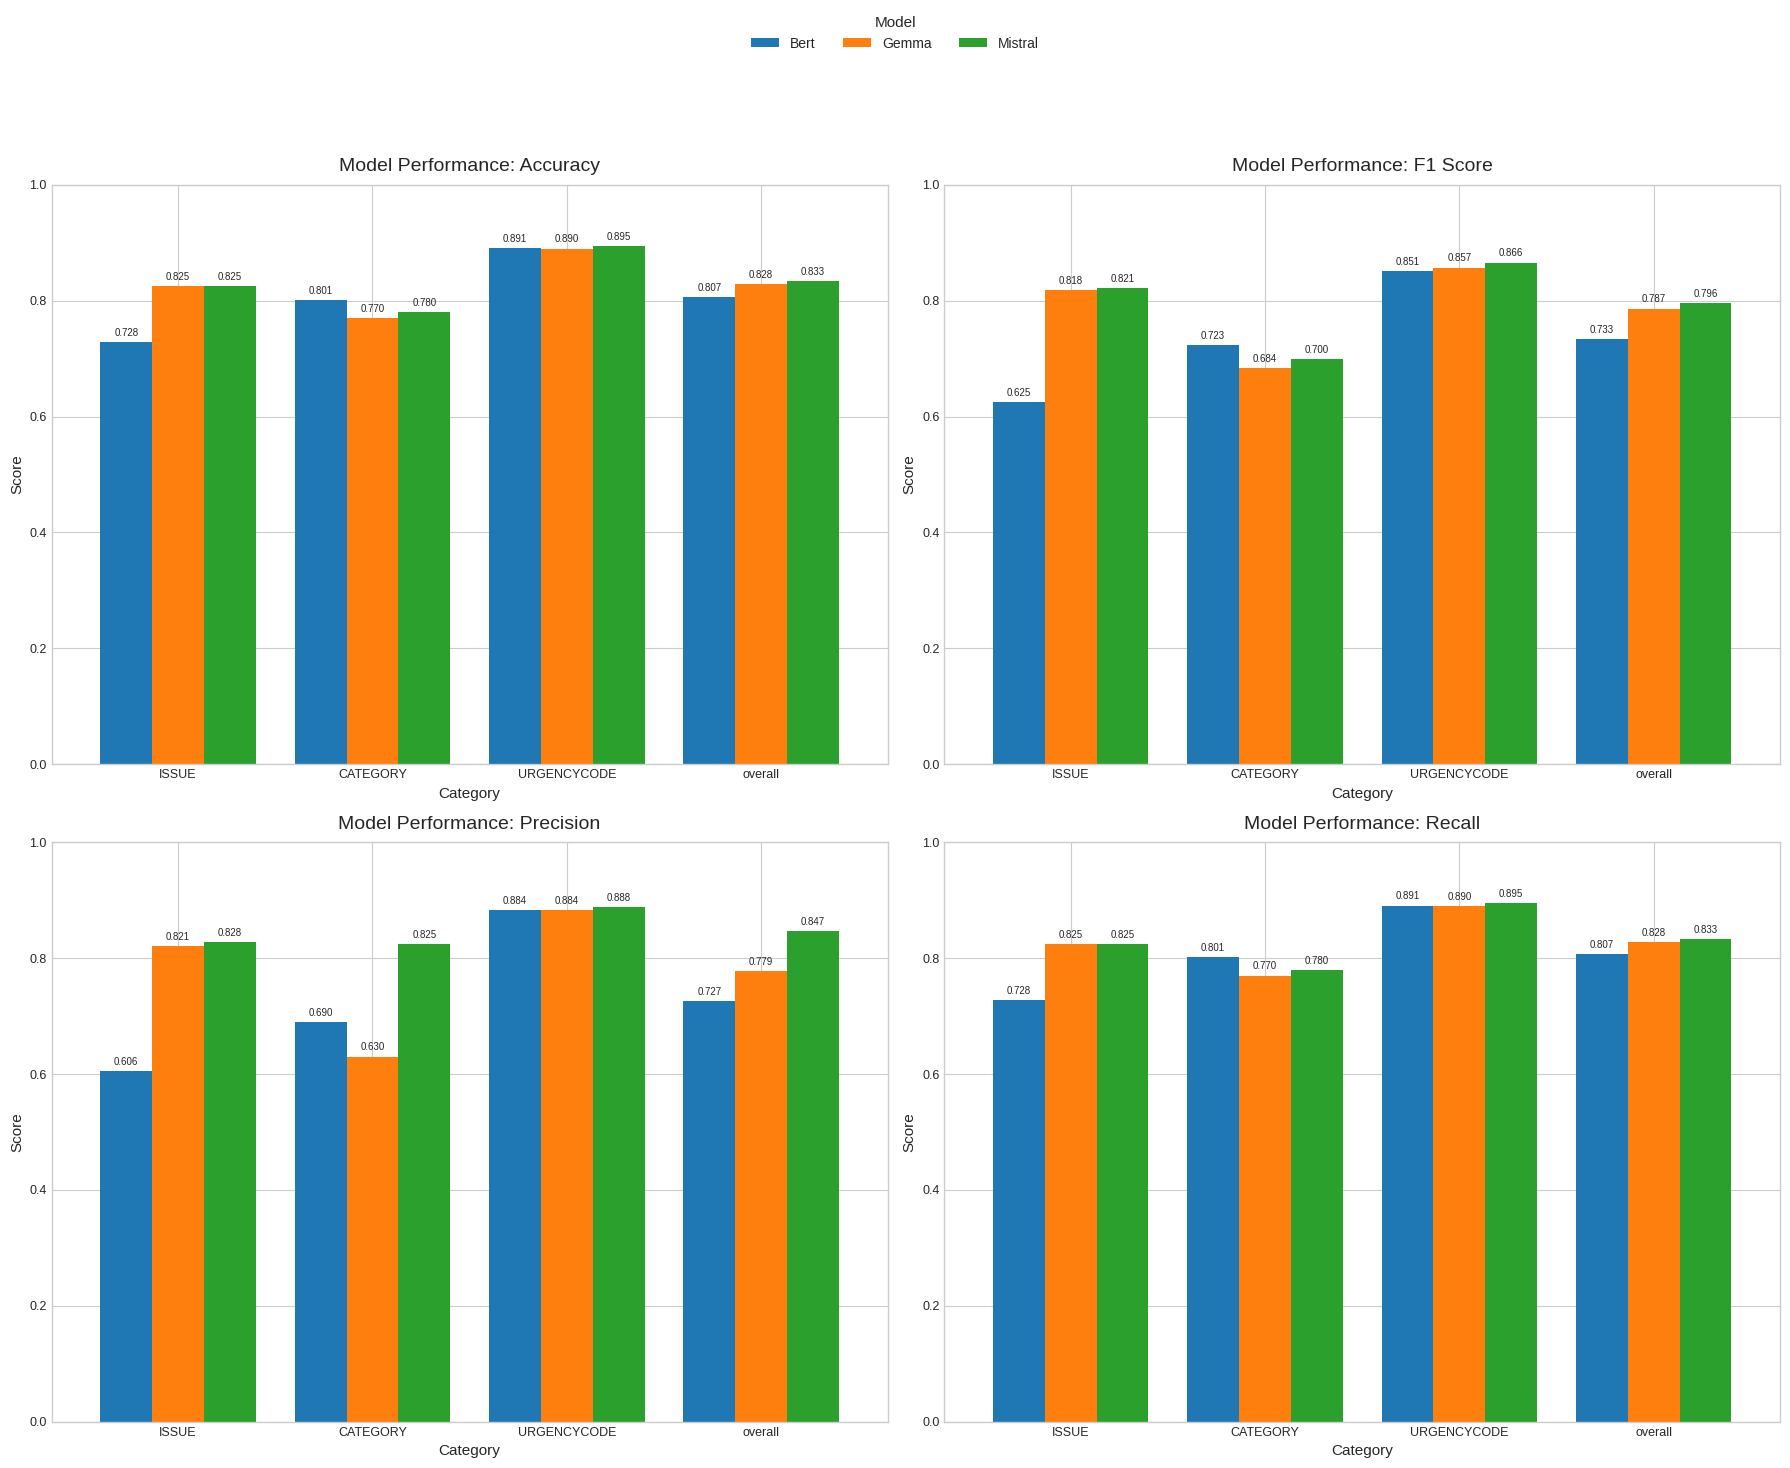

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Data provided by the user
data = {
    'Mistral': {
        "ISSUE": {
            "accuracy": 0.825,
            "f1_score": 0.821400200722,
            "precision": 0.8275517241379311,
            "recall": 0.825
        },
        "CATEGORY": {
            "accuracy": 0.78,
            "f1_score": 0.6999106082827012,
            "precision": 0.8248969072164948,
            "recall": 0.78
        },
        "URGENCYCODE": {
            "accuracy": 0.895,
            "f1_score": 0.8658901098901097,
            "precision": 0.8879166666666667,
            "recall": 0.895
        },
        "overall": {
            "accuracy": 0.8333333333333334,
            "f1_score": 0.7957336396316036,
            "precision": 0.8467884326736975,
            "recall": 0.8333333333333334
        }
    },
    'Bert': {
        "ISSUE": {
            "accuracy": 0.7282051282051282,
            "f1_score": 0.6249495058278494,
            "precision": 0.6057959401709402,
            "recall": 0.7282051282051282
        },
        "CATEGORY": {
            "accuracy": 0.8012820512820513,
            "f1_score": 0.7233631687664744,
            "precision": 0.6901547822017183,
            "recall": 0.8012820512820513
        },
        "URGENCYCODE": {
            "accuracy": 0.8910256410256411,
            "f1_score": 0.851186964762342,
            "precision": 0.8838558360042734,
            "recall": 0.8910256410256411
        },
        "overall_macro_average": {
            "accuracy": 0.8068376068376067,
            "f1_score": 0.7331665464522219,
            "precision": 0.726602186125644,
            "recall": 0.8068376068376067
        }
    },
    'Gemma': {
        "ISSUE": {
            "accuracy": 0.825,
            "f1_score": 0.8184075448361163,
            "precision": 0.8214041666666665,
            "recall": 0.825
        },
        "CATEGORY": {
            "accuracy": 0.77,
            "f1_score": 0.6839198286413708,
            "precision": 0.6301975945017183,
            "recall": 0.77
        },
        "URGENCYCODE": {
            "accuracy": 0.89,
            "f1_score": 0.8572612886859461,
            "precision": 0.8839248704663213,
            "recall": 0.89
        },
        "overall": {
            "accuracy": 0.8283333333333333,
            "f1_score": 0.7865295540544777,
            "precision": 0.7785088772115687,
            "recall": 0.8283333333333333
        }
    }
}

# Standardize Bert's overall key
if 'overall_macro_average' in data['Bert']:
    data['Bert']['overall'] = data['Bert'].pop('overall_macro_average')

# Prepare data for DataFrame
records = []
for model_name, model_data in data.items():
    for category, metrics in model_data.items():
        for metric_name, value in metrics.items():
            records.append({
                'Model': model_name,
                'Category': category,
                'Metric': metric_name,
                'Value': value
            })

df = pd.DataFrame(records)

# Plotting in a single figure with subplots
metrics_to_plot = ['accuracy', 'f1_score', 'precision', 'recall']
models = df['Model'].unique()
categories = df['Category'].unique()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) # 2x2 subplots
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Create the grouped bar chart on the current subplot
    subset_df = df[df['Metric'] == metric]
    pivot_df = subset_df.pivot(index='Category', columns='Model', values='Value')

    # Ensure consistent order of categories
    pivot_df = pivot_df.reindex(categories)

    pivot_df.plot(kind='bar', ax=ax, width=0.8)

    # Customize subplot
    ax.set_title(f'Model Performance: {metric.replace("_", " ").title()}', fontsize=14, pad=10)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_xlabel('Category', fontsize=11)
    ax.tick_params(axis='x', rotation=0, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_ylim(0, 1.0)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=7, padding=3)

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
# Place the legend in the upper middle
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(models), title='Model', fontsize=10, title_fontsize=11)

# Remove individual subplot legends
for ax in axes:
    ax.get_legend().remove()

# Adjusted tight_layout to make more space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Increased space at the top


# Save the figure
file_name = 'overall_model_comparison.png'
plt.savefig(file_name, bbox_inches='tight') # Use bbox_inches='tight' to include legend


print(f"Chart saved as {file_name}")

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Data provided by the user
data = {
    'Mistral': {
        "ISSUE": {
            "accuracy": 0.825,
            "f1_score": 0.821400200722,
            "precision": 0.8275517241379311,
            "recall": 0.825
        },
        "CATEGORY": {
            "accuracy": 0.78,
            "f1_score": 0.6999106082827012,
            "precision": 0.8248969072164948,
            "recall": 0.78
        },
        "URGENCYCODE": {
            "accuracy": 0.895,
            "f1_score": 0.8658901098901097,
            "precision": 0.8879166666666667,
            "recall": 0.895
        },
        "overall": {
            "accuracy": 0.8333333333333334,
            "f1_score": 0.7957336396316036,
            "precision": 0.8467884326736975,
            "recall": 0.8333333333333334
        }
    },
    'Bert': {
        "ISSUE": {
            "accuracy": 0.7282051282051282,
            "f1_score": 0.6249495058278494,
            "precision": 0.6057959401709402,
            "recall": 0.7282051282051282
        },
        "CATEGORY": {
            "accuracy": 0.8012820512820513,
            "f1_score": 0.7233631687664744,
            "precision": 0.6901547822017183,
            "recall": 0.8012820512820513
        },
        "URGENCYCODE": {
            "accuracy": 0.8910256410256411,
            "f1_score": 0.851186964762342,
            "precision": 0.8838558360042734,
            "recall": 0.8910256410256411
        },
        "overall_macro_average": {
            "accuracy": 0.8068376068376067,
            "f1_score": 0.7331665464522219,
            "precision": 0.726602186125644,
            "recall": 0.8068376068376067
        }
    },
    'Gemma': {
        "ISSUE": {
            "accuracy": 0.825,
            "f1_score": 0.8184075448361163,
            "precision": 0.8214041666666665,
            "recall": 0.825
        },
        "CATEGORY": {
            "accuracy": 0.77,
            "f1_score": 0.6839198286413708,
            "precision": 0.6301975945017183,
            "recall": 0.77
        },
        "URGENCYCODE": {
            "accuracy": 0.89,
            "f1_score": 0.8572612886859461,
            "precision": 0.8839248704663213,
            "recall": 0.89
        },
        "overall": {
            "accuracy": 0.8283333333333333,
            "f1_score": 0.7865295540544777,
            "precision": 0.7785088772115687,
            "recall": 0.8283333333333333
        }
    }
}

# Standardize Bert's overall key
if 'overall_macro_average' in data['Bert']:
    data['Bert']['overall'] = data['Bert'].pop('overall_macro_average')

# Prepare data for DataFrame
records = []
for model_name, model_data in data.items():
    for category, metrics in model_data.items():
        for metric_name, value in metrics.items():
            records.append({
                'Model': model_name,
                'Category': category,
                'Metric': metric_name,
                'Value': value
            })

df = pd.DataFrame(records)

# Plotting
metrics_to_plot = df['Metric'].unique()
models = df['Model'].unique()
categories = df['Category'].unique()

for metric in metrics_to_plot:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Create the grouped bar chart
    subset_df = df[df['Metric'] == metric]
    pivot_df = subset_df.pivot(index='Category', columns='Model', values='Value')

    # Ensure consistent order of categories
    pivot_df = pivot_df.reindex(categories)

    pivot_df.plot(kind='bar', ax=ax, width=0.8)

    # Customize plot
    ax.set_title(f'Model Performance Comparison: {metric.replace("_", " ").title()}', fontsize=16, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Category', fontsize=12)
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(title='Model', fontsize=10)
    ax.set_ylim(0, 1.0)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8, padding=3)

    plt.tight_layout()

    # Save the figure
    file_name = f'{metric}_comparison.png'
    plt.savefig(file_name)
    print(f"Chart saved as {file_name}")

    # Show the plot
    plt.show()